In [ ]:
# connect to gdrive
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
# import libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from collections import Counter
from tqdm import tqdm
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

from transformers import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='huggingface_hub.utils._auth')

# Import data

In [ ]:
# import datasets
train = pd.read_csv(path + 'train.csv'); train_labels = train['label'].tolist()
dev = pd.read_csv(path + 'dev.csv'); dev_labels = dev['label'].tolist()

In [ ]:
# show head
train.head()

,Claim,Evidence,label
0,We should introduce school vouchers,"Among the many educational reform efforts, suc...",0
1,We should legalize insider trading,The U.S. Securities and Exchange Commission wa...,0
2,We should subsidize investigative journalism,"The film won an Emmy Award (1980), George Polk...",0
3,We should further exploit nuclear power,a 2001 survey by the European Commission found...,1
4,We should ban whaling,The US and several other nations are whaling u...,0


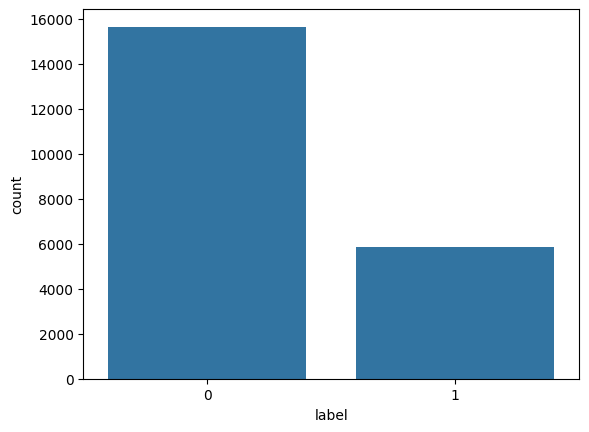

In [ ]:
# plot label distribution
sns.countplot(x='label', data=train)
plt.show()

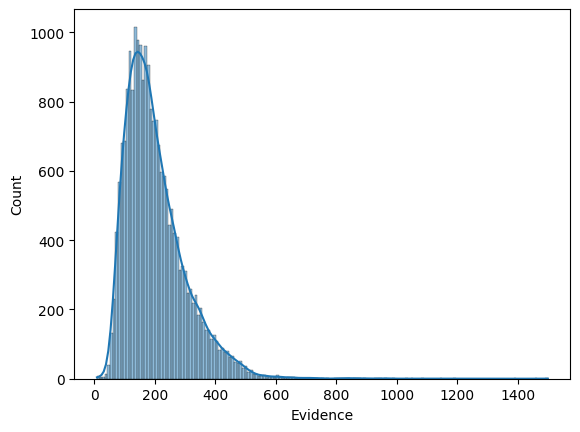

In [ ]:
# plot length distributions
lengths = train['Evidence'].str.len()
sns.histplot(lengths, kde=True)
plt.show()

# Preprocessing

In [ ]:
# tokenize sequences function
def tokenize_sequences(maxlen):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  train_encodings = tokenizer(train['Claim'].tolist(), train['Evidence'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=maxlen)
  dev_encodings = tokenizer(dev['Claim'].tolist(), dev['Evidence'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=maxlen)

  return train_encodings, dev_encodings

In [ ]:
# create class to convert our data to dataset objects
class InputDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "token_type_ids": self.encodings["token_type_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.float)
        }

In [ ]:
# convert to dataloader objects ready for model input
def create_dataloaders(maxlen, batchsize):
  train_encodings, dev_encodings = tokenize_sequences(maxlen)

  train_dataset = InputDataset(train_encodings, train_labels)
  train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
  dev_dataset = InputDataset(dev_encodings, dev_labels)
  dev_dataloader = DataLoader(dev_dataset, batch_size=batchsize, shuffle=True)

  return train_dataloader, dev_dataloader

# Model Design

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# function to create model and set up optimizer and lr_scheduler
def create_model(hp, train_dataloader):
  model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

  model.dropout = torch.nn.Dropout(hp['c_dropout']) #set dropout in classification head
  for module in model.bert.modules(): #set dropout in encoder layers
    if isinstance(module, torch.nn.Dropout):
        module.p = hp['e_dropout']

  if hp['use_lora']:
    lora_config = LoraConfig(r=16, lora_alpha=32, target_modules=["query", "value"], lora_dropout=0.05, bias="none", task_type=TaskType.SEQ_CLS, inference_mode=False)
    model = get_peft_model(model, lora_config)

  model.to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=hp['learning_rate'], weight_decay=hp['weight_decay'])
  lr_scheduler = get_scheduler('linear', optimizer=optimizer, num_warmup_steps=hp['warmup_steps'], num_training_steps=hp['epochs'] * len(train_dataloader))

  return model, optimizer, lr_scheduler

In [ ]:
# function to compute class weights to mitigate class imbalance
def compute_class_weights(mode):
  label_counts = Counter(train_labels)
  class_0 = label_counts[0]; class_1 = label_counts[1]
  total = class_0 + class_1

  if mode == 'inverse':
    weight_0 = total / class_0; weight_1 = total / class_1
  elif mode == 'balanced':
    weight_0 = total / (2 * class_0); weight_1 = total / (2 * class_1)
  elif mode == 'log':
    weight_0 = np.log(total / class_0); weight_1 = np.log(total / class_1)
  elif mode == 'sqrt':
    weight_0 = np.sqrt(total / class_0); weight_1 = np.sqrt(total / class_1)
  else:
    raise ValueError('Invalid mode')

  class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float)
  return class_weights

In [ ]:
# evaluation function to use during training
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).long()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")

    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
def train_model(hp, train_dataloader, dev_dataloader):
  model, optimizer, lr_scheduler = create_model(hp, train_dataloader)
  class_weights = compute_class_weights(hp['weighting_mode'])

  # Track best model
  best_f1 = 0.0; best_epoch = 0
  history, t_history = [], []

  # Training loop
  for epoch in range(hp['epochs']):
      print(f"Epoch {epoch + 1}/{hp['epochs']}")
      model.train()
      loop = tqdm(train_dataloader, leave=True, disable=False)

      for batch in loop:
          # Move batch data to device
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device).long()

          # Forward pass
          outputs = model(input_ids, attention_mask=attention_mask)
          logits = outputs.logits
          loss = F.cross_entropy(logits, labels, weight=class_weights.to(device))

          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          lr_scheduler.step()

          # # Update progress bar
          loop.set_description(f'Epoch {epoch}')
          loop.set_postfix(loss=loss.item())

      # Evaluate after epoch
      metrics = evaluate(model, dev_dataloader); t_metrics = evaluate(model, train_dataloader)
      history.append({'epoch': epoch + 1, **metrics}); t_history.append({'epoch': epoch + 1, **t_metrics})

      # Save best model
      if metrics['f1'] > best_f1:
          best_f1 = metrics['f1']; best_epoch = epoch + 1
          torch.save(model.state_dict(), path + 'model.pt')
  return history, t_history, best_epoch

# Model Development

## hyperparameters

In [ ]:
hp = {
    'batchsize': 8,
    'learning_rate': 2e-4,
    'weighting_mode': 'inverse',
    'weight_decay': 5e-5,
    'warmup_steps': 1210,
    'e_dropout': 0.05,
    'c_dropout': 0.15,
    'maxlen': 128,
    'use_lora': True,
    'epochs': 5
}

## hp tuning

In [ ]:
def train_x_times(hp, train_loader, dev_loader, x=3):
  f1s, accuracies, train_f1s, train_accuracies = [], [], [], []

  for i in range(x):
    print(f'run {i+1}/{x}:')
    # run training
    history, t_history, ep = train_model(hp, train_loader, dev_loader)

    # store metrics
    f1s.append(history[ep - 1]['f1'])
    accuracies.append(history[ep - 1]['accuracy'])
    train_f1s.append(t_history[ep - 1]['f1'])
    train_accuracies.append(t_history[ep - 1]['accuracy'])

    torch.cuda.empty_cache() # clear cache

  # compute averages over x runs
  avg_accuracy = sum(accuracies) / x
  avg_f1 = sum(f1s) / x
  avg_train_accuracy = sum(train_accuracies) / x
  avg_train_f1 = sum(train_f1s) / x

  print(f'accuracies: {accuracies}. Ave:{avg_accuracy}')
  print(f'f1s: {f1s}. Ave:{avg_f1}')

  return avg_accuracy, avg_f1, avg_train_accuracy, avg_train_f1


In [ ]:
# whatever parameter to be tuned here
rangeHP = [3,4,5,6,7,8,9]
bestF1 = 0
bestParam = 0
f1s, accuracies, train_f1s, train_accuracies = [], [], [], []
paramName = 'epochs'

for param in rangeHP:
    print(f'\n{paramName}: {param}')
    tempHP = hp.copy()
    tempHP[paramName]= param

    train_dataloader, dev_dataloader = create_dataloaders(tempHP['maxlen'], tempHP['batchsize'])
    acc, f1, train_acc, train_f1 = train_x_times(tempHP, train_dataloader, dev_dataloader, x=3)

    f1s.append(f1)
    accuracies.append(acc)
    train_f1s.append(train_f1)
    train_accuracies.append(train_acc)

    if f1 > bestF1:
        bestF1 = f1
        bestParam = param


epochs: 3


KeyboardInterrupt: 

In [ ]:
# plot results
plt.figure(figsize=(10, 6))
plt.plot(rangeHP, train_accuracies, label='Train Accuracy', marker='x', linestyle='--', color= 'orange')
plt.plot(rangeHP, accuracies,   label='Validation Accuracy', marker='x', color= 'orange')
plt.plot(rangeHP, train_f1s, label='Train f1', marker='o', color= 'blue', linestyle='--')
plt.plot(rangeHP, f1s,   label='Validation f1', marker='o', color= 'blue')
# plt.ylim(0.4, 1.05)
plt.xlabel("hyper-parameter"); plt.ylabel("metric"); plt.title(paramName); plt.grid(True); plt.legend(); plt.show()

print(f'parameters: {rangeHP}'); print(f'best param: {bestParam}'); print([f"{a:.3f}" for a in accuracies])

# Model Evaluation

In [ ]:
# train model on chosen hyperparameters
train_dataloader, dev_dataloader = create_dataloaders(hp['maxlen'], hp['batchsize'])
history, t_history, _ = train_model(hp, train_dataloader, dev_dataloader)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/5


Epoch 0: 100%|██████████| 2689/2689 [05:16<00:00,  8.50it/s, loss=0.672]


Epoch 2/5


Epoch 1: 100%|██████████| 2689/2689 [05:19<00:00,  8.43it/s, loss=0.0297]


Epoch 3/5


Epoch 2: 100%|██████████| 2689/2689 [05:19<00:00,  8.41it/s, loss=0.27]


Epoch 4/5


Epoch 3: 100%|██████████| 2689/2689 [05:20<00:00,  8.40it/s, loss=0.0308]


Epoch 5/5


Epoch 4: 100%|██████████| 2689/2689 [05:18<00:00,  8.44it/s, loss=0.0507]


In [ ]:
def load_best_model():
  # initialize model
  model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
  if hp['use_lora']:
    lora_config = LoraConfig(r=16, lora_alpha=32, target_modules=["query", "value"], lora_dropout=0.05, bias="none", task_type=TaskType.SEQ_CLS, inference_mode=True)
    model = get_peft_model(model, lora_config)

  # load model weights
  model.load_state_dict(torch.load(path + 'model.pt'))

  # apply quantization if lora is not in use
  if not hp['use_lora']:
    model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

  model.to(device)
  return model

In [ ]:
def evaluate_model(model, dev_dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dev_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # print metrics
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, digits=4))
    print('Confusion Matrix:')
    print(confusion_matrix(all_labels, all_preds))

In [ ]:
# load best_model + print evalution report and confusion matrix
device = 'cuda'
model = load_best_model()
evaluate_model(model, dev_dataloader)

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9284    0.8866    0.9070      4286
         1.0     0.7349    0.8213    0.7757      1640

    accuracy                         0.8685      5926
   macro avg     0.8316    0.8540    0.8414      5926
weighted avg     0.8748    0.8685    0.8707      5926

Confusion Matrix:
[[3800  486]
 [ 293 1347]]


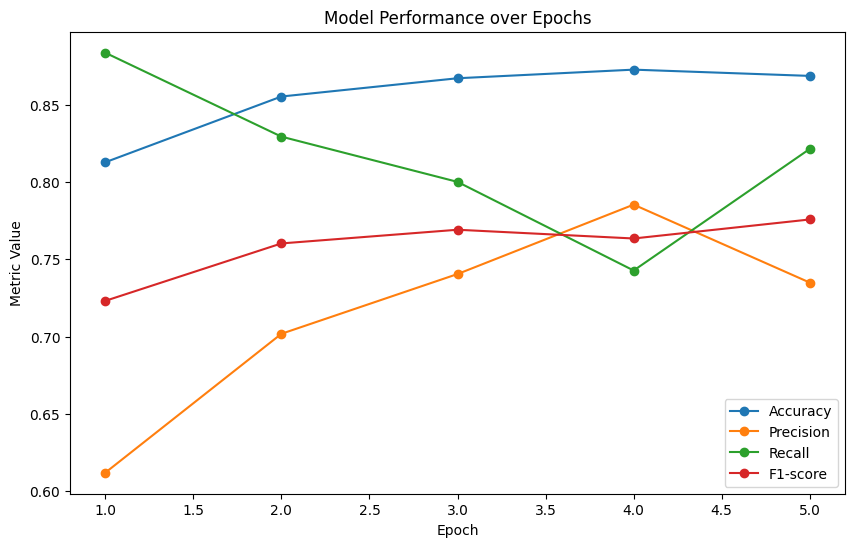

In [ ]:
# plot validation metrics over epochs
epochs = [entry['epoch'] for entry in history]
accuracy = [entry['accuracy'] for entry in history]
precision = [entry['precision'] for entry in history]
recall = [entry['recall'] for entry in history]
f1 = [entry['f1'] for entry in history]

plt.figure(figsize=(10, 6))

plt.plot(epochs, accuracy, label='Accuracy', marker='o')
plt.plot(epochs, precision, label='Precision', marker='o')
plt.plot(epochs, recall, label='Recall', marker='o')
plt.plot(epochs, f1, label='F1-score', marker='o')

plt.xlabel('Epoch'); plt.ylabel('Metric Value')
plt.title('Model Performance over Epochs')
plt.legend(); plt.show()

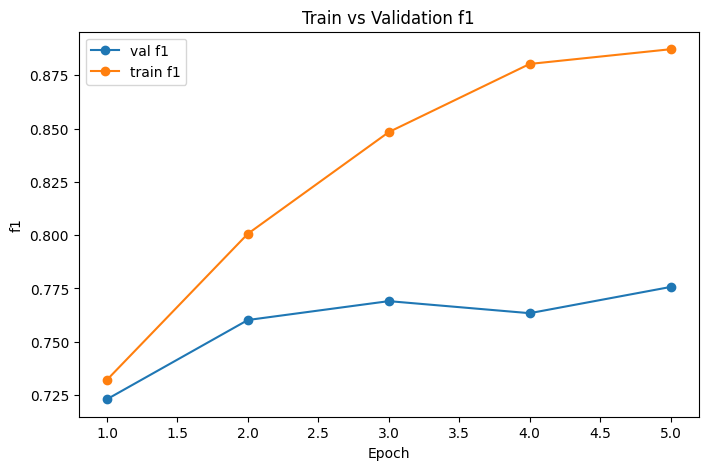

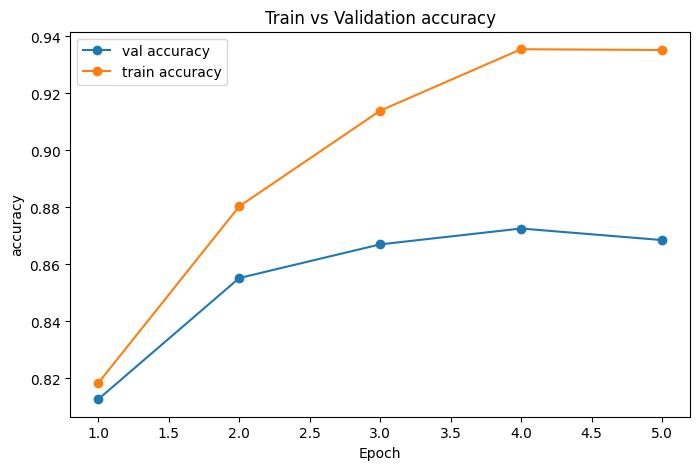

In [ ]:
# plot train vs validation
def plot_train_vs_val(history, t_history, metric):
    epochs = [entry['epoch'] for entry in history]
    v_metric = [entry[metric] for entry in history]
    t_metric = [entry[metric] for entry in t_history]

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, v_metric, marker='o', label=f'val {metric}')
    plt.plot(epochs, t_metric, marker='o', label=f'train {metric}')

    plt.title(f'Train vs Validation {metric}')
    plt.xlabel('Epoch'); plt.ylabel(metric)
    # plt.ylim(0, 1.05); plt.grid(True)
    plt.legend(); plt.show()

plot_train_vs_val(history, t_history, metric='f1')
plot_train_vs_val(history, t_history, metric='accuracy')